# Finding Charity Donors with Supervised Machine Learning

## Getting Started

In this project, I employed several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I then chose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with implementation was to construct a model that accurately predicted whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [1]:
# Import libraries necessary for this project
import sys
!{sys.executable} -m pip install numpy pandas matplotlib sklearn scipy   #Imports Python2 versions of numpy, matplotlib, pandas, sci-kit learn into jupyter for use with Python2 kernel
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
#n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
#n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

#**Shortcut**
n_at_most_50k, n_greater_50k = data.income.value_counts()

# Percentage of individuals whose income is more than $50,000
greater_percent = float((float(n_greater_50k)/ float(n_records)) * 100)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

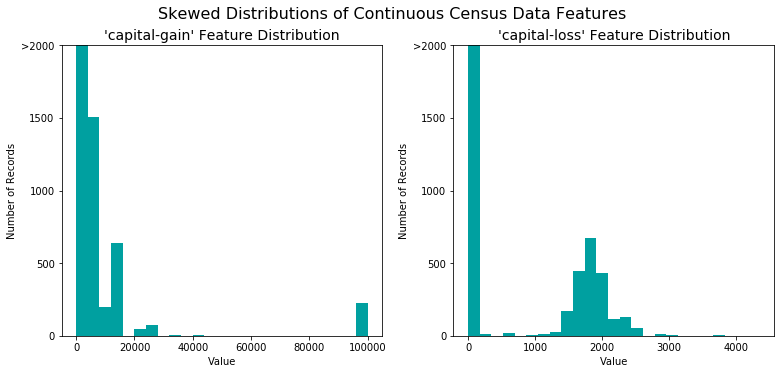

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

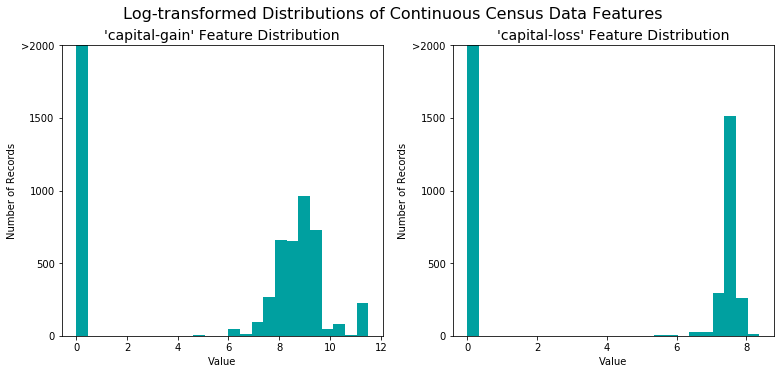

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

##Binarizer also works well for this 
##from sklearn.preprocessing import LabelBinarizer
##lb_style = LabelBinarizer()
##income = lb_style.fit_transform(income_raw)

##Also worth checking out label encoder
##encoder = LabelEncoder()
##income = encoder.fit_transform(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split
##from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

I would choose the following three supervised learning models:

**Gaussian Naive Bayes**
- Real World Application:
   - Used by Google to classify emails as spam/not spam.
- Strengths: 
   - This is a very simple algorithm that just does a bunch of counts. If the Naive Bayes conditional independence assumption actually holds (or if feature dependence is distributed evenly across features - http://www.aaai.org/Papers/FLAIRS/2004/Flairs04-097.pdf), then a Naive Bayes classifier will converge quicker than other discriminative models like logistic regression, so less training data is needed. In other words, Naive Bayes will perform well if there are no feature interactions, or if those interactions are distributed evenly. 
- Weaknessses:
   - It can’t learn interactions between features (e.g., it can’t learn that although you love chocolate and strawberry ice cream, you hate them when they’re together). So if the data does have feature interactions then it will likely perform poorly.
- What makes this model a good candidate for the problem, given what you know about the data?
   - Since we have a relatively small dataset and since we're not exactly sure if there are interactions between features this is likely a very good candidate for making a simple decision like 'is this person's income >= 50k based on the other features present'. However, it could also fail miserably if there are unevenly distributed interactions between the features.

**Decision Tree**
- Real World Application:
   - Decision Trees are often applied to customer relationship management systems (CRMs). For example, they can be used to investigate the relationships between the customers’ needs and preferences and the success of online shopping (Lee et al. 2007).
- Strengths: 
   - They easily handle feature interactions (one-up over Naive Bayes) and they’re non-parametric, so you don’t have to worry about outliers or whether the data is linearly separable. They’re also fast and scalable, and you don’t have to worry about tuning a bunch of parameters like you do with other classifiers like SVMs. In this case, if the data includes feature interactions that are not linearly-separable, then a Decision Tree will still perform well.
- Weaknessses:
   - One disadvantage is that they don’t support online learning, so you have to rebuild your tree when new examples come on. Another disadvantage is that they easily overfit, but that’s where ensemble methods like random forests (or boosted trees) come in. In this case overfitting may occur, which is why the next algorithm I chose incorporates an ensemble method.
- What makes this model a good candidate for the problem, given what you know about the data?
   - Since Decision Trees can easily handle feature interactions without sacrificing much in speed or cost they seem like a good alternative to Naive Bayes in the event that feature interactions are present in the data.

**AdaBoost (using Decision Tree)**
- Real World Application:
   - AdaBoost is an ensemble boosting method (aka meta algorithm) that can be used as a wrapper for a number of other learning algorithms and is used in real world applications such as face detection.
- Strengths: 
   - AdaBoost works by creating a highly accurate classifier by combining many relatively weak and inaccurate classifiers. It can achieve similar classification results with much less tweaking of parameters or settings (unless used as a wrapper for SVM). The user only needs to choose: (1) which weak classifier might work best to solve their given classification problem; (2) the number of boosting rounds that should be used during the training phase. One can also add several weak classifiers to the family of weak classifiers that should be used at each round of boosting and the AdaBoost algorithm will select the weak classifier that works best at that round of boosting.   
- Weaknessses:
   - AdaBoost can be sensitive to noisy data and outliers. In some cases, however, it can be less susceptible to the overfitting problem than most learning algorithms. 
- What makes this model a good candidate for the problem, given what you know about the data?
   - I believe that this might be an improvement upon a simple Decision Tree because it can use multiple weak learning Decision Trees in order to tackle the hardest (most misclassified) instances first, thereby converging faster.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = float(end - start)
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = float(end - start)
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


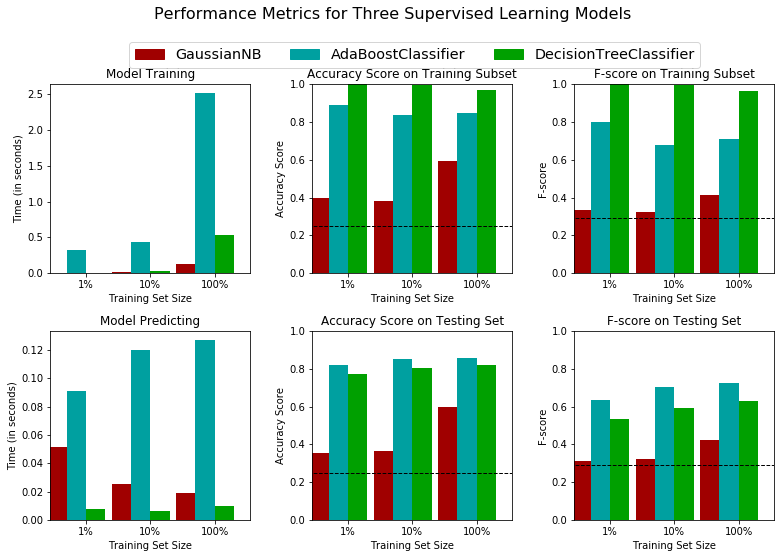

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0) #defaults to DecisionTreeClassifier

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*.1)
samples_1 = int(len(y_train)*.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

### Notes 

I believe that the most appropriate model to use would be the DecisionTreeClassifier. **Overall** this model performed better than both the Naive Bayes classifier and the AdaBoost classifier (boosted forest) when considering prediction/training time, prediction/training accuracy, and prediction/training Fbeta score. **Although Adaboost outperformed the DecisionTreeClassifier in the designated measure of performance (F-score), I believe that the F-score of the DecisionTreeClassifier can be improved substantially during hyperparameter tuning (through pruning, criterion switching, min_sample_split, etc.) without sacrificing speed, whereas it is unlikely that the speed of Adaboost can be reduced to match anything close to that of the DecisionTreeClassifier because of its reliance on sequentially trained multiple weak learners.** Not only did the DecisionTreeClassifier perform the fastest with a prediction time of less than 0.01 seconds on 100% of the test data, but it also generalized relatively well over the test data with an accuracy score of 0.8186 and an Fbeta score of 0.6279, coming about 0.1 behind the 'Adaboosted' forest in terms of Fbeta score accuracy on the test set while outperforming Adaboost in prediction time by .1 seconds. Therefore, I believe the DecisionTreeClassifier is the most appropriate model when considering the overall performance/accuracy tradeoff (very fast performance for relatively low bias). My only concern is that the DeicisionTreeClassifier may have overfit the data because it achieved approximately .95 accuracy and fbeta score on the training data, indicating that it may not be generalizing as well as it could onto the test data. However, there is still alot of room for hyperparameter tuning with the DecisionTreeClassifier so my hope is that the Fbeta score can be improved without sacrificing speedy performance.

The DecisionTreeClassifier works by utilizing an algorithm called ID3 which figures out which features from the data carry the most weight in predicting correctly whether a person makes >$50K (in mathematical terms it picks the best order for 'splitting' features that allows us to make accurate predictions about a person's income without needing to know all the other features -- similar to finding an optimal strategy for playing a game of 20 questions without needing to ask all 20 questions). Then when the algorithm goes to make predictions it starts with those features that it identified as having the highest likelihood of helping us accurately guess a person's income. 

In order for the algorithm to make accurate predictions on new data we first need to train it to identify the most important features that go into predicting income, and in this case we use a bunch of data from the 1994 US Census for that very purpose. We then test the trained algorithm on a separate set of independent data drawn from the same census, which we call the test set, and we see how well it performs. In this case it performs reasonably well with an accuracy score of 0.8186 and an Fbeta score of 0.6279 on the test data.

*Note that in this case the Fbeta score helps us properly weight the influence of true positive classifications in relation to both true and false positives. Remember that we want to prioritize both the correct classification of potential donors and the misclassification of non-potential donors.

### Implementation: Model Tuning

In [16]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'criterion':('gini', 'entropy'), 'min_samples_split':[2, 5, 10], 'max_depth':[None, 2, 5, 10], 'min_impurity_decrease':[0, 2, 5, 10]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print(fbeta_score(y_test, predictions, beta=0.5))
print(fbeta_score(y_test, best_predictions, beta=0.5))

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

0.627939142462
0.722556476331
Unoptimized model
------
Accuracy score on testing data: 0.8186
F-score on testing data: 0.6279

Optimized Model
------
Final accuracy score on the testing data: 0.8552
Final F-score on the testing data: 0.7226


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8186      |     0.8552      |
| F-score        |       0.6279      |     0.7226      |


### Notes 

The final optimized model's accuracy improved by 3.66% and its F-score improved by 9.47%!

This is a major improvement on the unoptomized model, and exactly what I was hoping for in regards to F-score. It seems like the DecisionTreeClassifier was overfitting but the pruning and max-depth tuning applied during grid search helped to significantly reduce variance.

It almost goes without saying that these results are far superior compared to the results of the naive predictor benchmarks from Question 1 (accuracy improvement of 60.74% and F-score improvement of 43.09%).


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Notes 

I believe the five most important features for prediction from the census data are (in order of importance):
1. **Age** because older people are more likely to be mature in their careers and therefore make more money
2. **Capital Gain** because usually only wealthy people have the discretionary income to invest and incur capital gains
3. **Education Level** because better educated people have a higher likelihood of taking on high skill jobs that pay better salaries
4. **Sex** because men are historically paid more than women for equal labor, and because a higher proportion of women are likely to make part-time salaries or revert to child care and leave the professional work force altogether.
5. **Marital Status** because marriage is often an indicator of wealth given the high cost of marriage itself as well as the common perception that those who are married are also often gainfully employed.


### Implementation - Extracting Feature Importance

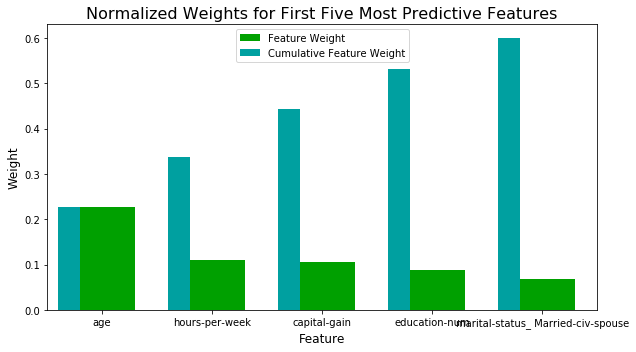

In [12]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Notes

I correctly predicted age, capital gain, marital status, and education. However I completely missed hours-per-week, although it does make sense if one considers that certain amounts of hours might be more correlated with certain low or high-wage careers (investment bankers working 80+ hours per week are paid very well, and part time workers are likely paid much less). 

The visualization confirms my thoughts that age and capital gain are two of the most importrant features, since they seem to correlate directly with career maturity and access to investment income respectively. Marriage and education also play an important role, although just from looking at the data one isn't really able to make any definitive conclusions about why these features play the most prominent role in predicting income.

### Feature Selection


In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8552
F-score on testing data: 0.7226

Final Model trained on reduced data
------
Accuracy on testing data: 0.8451
F-score on testing data: 0.6927


### Conclusion 

The final model's F-score on the reduced testing data decreases noticeably (by 2.99%) and its accuracy decreases marginally (by .01%).

If training time was the most important factor I would still consider using the reduced data as my training set, however given that I already optimized for speed by picking the DecisionTreeClassifier over AdaBoost I think I would probably continue to use the full data.